In [63]:
%matplotlib inline
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

cwd = os.getcwd()
print(cwd)
bike_dataFrame = pd.read_csv(cwd + "/SeoulBikeData.csv",encoding='latin1')

/Users/pramitchatterjee/Desktop/BikeLinearModels


# Exploratory Data Analysis
## Overview

In [64]:
print(bike_dataFrame.head(5))

         Date  Rented Bike Count  Hour  Temperature(°C)  Humidity(%)  \
0  01/12/2017                254     0             -5.2           37   
1  01/12/2017                204     1             -5.5           38   
2  01/12/2017                173     2             -6.0           39   
3  01/12/2017                107     3             -6.2           40   
4  01/12/2017                 78     4             -6.0           36   

   Wind speed (m/s)  Visibility (10m)  Dew point temperature(°C)  \
0               2.2              2000                      -17.6   
1               0.8              2000                      -17.6   
2               1.0              2000                      -17.7   
3               0.9              2000                      -17.6   
4               2.3              2000                      -18.6   

   Solar Radiation (MJ/m2)  Rainfall(mm)  Snowfall (cm) Seasons     Holiday  \
0                      0.0           0.0            0.0  Winter  No Holiday   


In [65]:
bike_dataFrame.describe()

,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm)
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [66]:
bike_dataFrame.dtypes

Date                          object
Rented Bike Count              int64
Hour                           int64
Temperature(°C)              float64
Humidity(%)                    int64
Wind speed (m/s)             float64
Visibility (10m)               int64
Dew point temperature(°C)    float64
Solar Radiation (MJ/m2)      float64
Rainfall(mm)                 float64
Snowfall (cm)                float64
Seasons                       object
Holiday                       object
Functioning Day               object
dtype: object

### We drop the date because we want the model to not overfit, and to make future predictions based on the conditions on a given day in the future, irrespective of the date
### 


In [67]:
bike_dataFrame = bike_dataFrame.drop(["Date"],axis=1)

## Visualizing the correlations of the features and target using seaborne clustermap

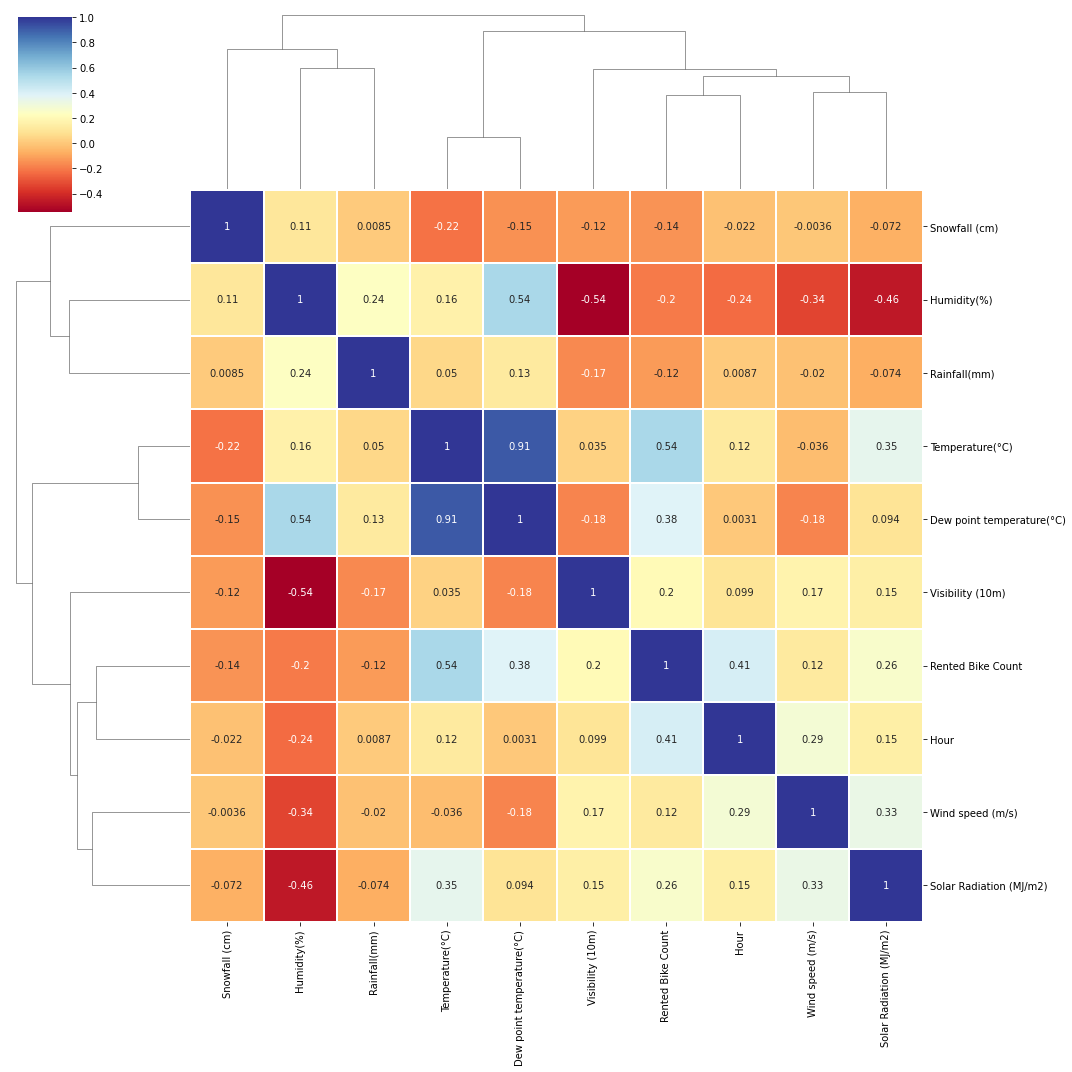

In [68]:
df_cluster = bike_dataFrame.corr()
plot_kws={"s": 1}
sns.clustermap(df_cluster,
            cmap='RdYlBu',
            linewidths=0.1,
            figsize=(15,15),
               annot=True)

Now we want to view the attributes that have a high correlation (>0.6). We want to avoid features that are highly corelated to each other 

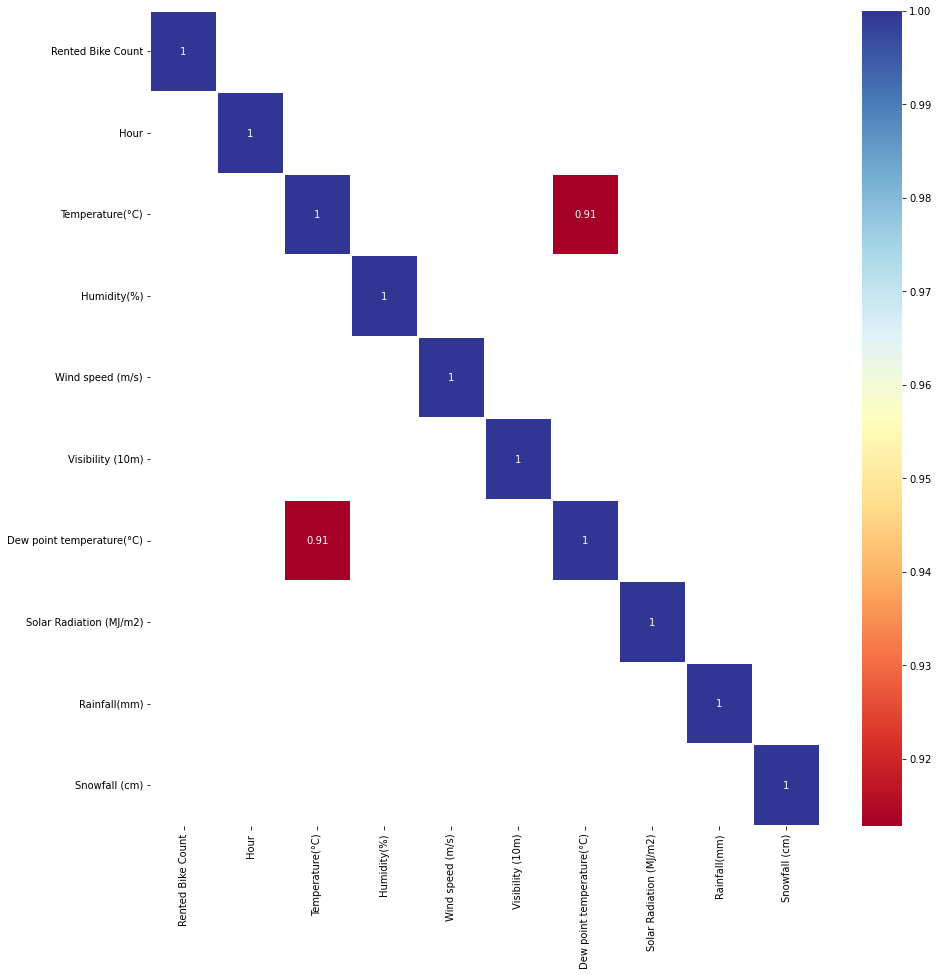

In [69]:
plt.figure(figsize=(15,15))
threshold = 0.6
mask = df_cluster.where((abs(df_cluster) >= threshold)).isna()
plot_kws={"s": 1}
sns.heatmap(df_cluster,
            cmap='RdYlBu',
            annot=True,
            mask=mask,
            linewidths=0.2, 
            linecolor='white').set_facecolor('white')

### We observe that the Dew point temperature(°C) is highly correlated to Temperature(°C), so we are going to drop the column "Dew point temperature(°C)" to avoid multicoliearity.

In [70]:
bike_dataFrame = bike_dataFrame.drop("Dew point temperature(°C)",axis=1)

### We now check for columns that have skew more than 0.75, so that we can apply a log transform on them

In [71]:
# Create a list of float colums to check for skewing
mask = bike_dataFrame.dtypes == np.float
float_cols = bike_dataFrame.columns[mask]
#check the columns that have a skew of more than 0.75
skew_limit = 0.75
skew_vals = bike_dataFrame[float_cols].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skew'})
             .query('abs(Skew) > {0}'.format(skew_limit)))

skew_cols


/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/1788119663.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = bike_dataFrame.dtypes == np.float


,Skew
Rainfall(mm),14.533232
Snowfall (cm),8.440801
Solar Radiation (MJ/m2),1.504040
Wind speed (m/s),0.890955


The features that are skewed have a minimum value of zero or more. So we apply log1p to improve their skewness

In [72]:
for col in skew_cols.index.tolist():
    bike_dataFrame[col] = np.log1p(bike_dataFrame[col])

### Now we separate the features as X and the target as Y, and identify the numerical and categorical features inside X. The numeric features need to be scaled using standard scaling. Since all of the categorical features are  non-ordinal, we proceed with one hot encoding.

We use a column transformer to achieve this

In [73]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder

feature_cols = [x for x in bike_dataFrame.columns if (x != "Rented Bike Count")]
X = bike_dataFrame[feature_cols]
Y = bike_dataFrame["Rented Bike Count"]

ss = StandardScaler()

numeric_features = X.dtypes[bike_dataFrame.dtypes != np.object]  # filtering by non-string
numeric_features = numeric_features.index.tolist()  # list of categorical fields
numeric_transformer = StandardScaler()

categorical_features = one_hot_encode_cols
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])
X=preprocessor.fit_transform(X)



/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/17159027.py:10: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  numeric_features = X.dtypes[bike_dataFrame.dtypes != np.object]  # filtering by non-string


# Training, Tuning and Analyzing Regression Models
We want to come up with regression models, tune their hyperparameters, and apply them on test data to check their capabilities in predicting unseen data. So we split the data into training data and test data. We will perform grid search with 5 fold cross validation on the training data for tuning the hyperparameters, and then train the models with the best hyperparameters on the entire training data, and calculate performance metrics on the test data.

We start with splitting the data into a training set(75 percent) and test set(25 percent)

In [74]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=10)

Cross Validation with 5 folds

In [75]:
from sklearn.model_selection import KFold, cross_val_predict
kf = KFold(shuffle=True, random_state=7201, n_splits=5)

## We now perform polynomial regression with 5 fold cross validation on the training set and check which degree is best suited

In [76]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.pipeline import Pipeline


for i in range(1,5,1):
    poly = PolynomialFeatures(degree=i, include_bias=False)
    regr = LinearRegression()
    
    estimator = Pipeline([
    ("make_higher_degree", poly),
    ("linear_regression", regr)])
    
    predictions = cross_val_predict(estimator,X_train, Y_train, cv=kf)
    print(i," score ",r2_score(Y_train, predictions))

1  score  0.5555208701749472
2  score  0.7163346458531086
3  score  -1976803679393515.5
4  score  -7.423198218205629e+20


We select the degree as 2, train the model on the entire training set and get the performance on the test set

In [109]:
poly = PolynomialFeatures(degree=2, include_bias=False)
regr = LinearRegression()

estimator = Pipeline([
("make_higher_degree", poly),
("lasso_regression", regr)])

estimator.fit(X_train,Y_train)
Y_pred_poly = estimator.predict(X_test)

mse = mean_squared_error(Y_test,Y_pred_poly)
rmse = np.sqrt(mse)

print("RMSE",rmse,"R2 score",r2_score(Y_test, Y_pred_poly))


RMSE 340.5300672811248 R2 score 0.7071404636291061


## Actual Vs Predicted Plot

/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/4071496061.py:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/4071496061.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


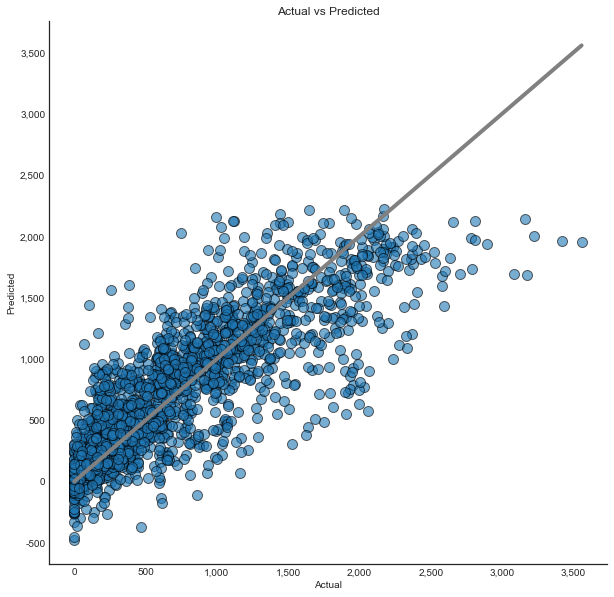

In [110]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=10,10 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=Y_test,
                y=Y_pred_poly,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(Y_test),max(Y_test)],
             y=[min(Y_test),max(Y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

### we get an R2 Score of 70.7 percent. If we observe the plot, we can see that the model does a better job predicting values that are relatively low. As the target variable increases, our model starts consistently predicting lower than actual values. Overall, the model does not do the best job at predicting demands, and the points seem unevenly scattered away from the line. Thus, we look into other regression models

### We now design a Ridge regression model fitted on polynomial data. For coming up with the degree to fit the data, and the alpha value for ridge regression, we run a grid search with the same cross validation on the training set.

In [112]:
# Mute the sklearn warning about regularization
import warnings
warnings.filterwarnings('ignore', module='sklearn')

from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(include_bias=False)),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3,4],
    'ridge_regression__alpha': [0.001,0.01, 1.0, 10.0,100]
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train, Y_train)
grid.best_score_, grid.best_params_

(0.8056866180737579,
 {'polynomial_features__degree': 3, 'ridge_regression__alpha': 10.0})

The best score is observed for degree = 3 and alpha = 100. We train the entire training set based on these hyperparameters and calculate the score on the test set

In [108]:
# The ridge regression model
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=3,include_bias=False)),
        ("ridge_regression", Ridge(alpha=100))])

estimator.fit(X_train,Y_train)
Y_pred_rr = estimator.predict(X_test)

mse = mean_squared_error(Y_test,Y_pred_rr)
rmse = np.sqrt(mse)
print(" rmse ",rmse," score ",r2_score(Y_test, Y_pred_rr))

 rmse  286.2124716846923  score  0.7931166450111221


## Actual Vs Predicted Plot

/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/1474441381.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/1474441381.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


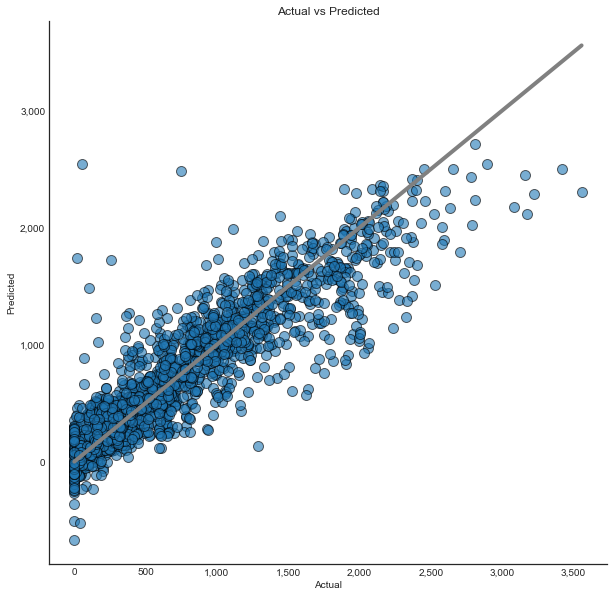

In [101]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=10,10 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=Y_test,
                y=Y_pred_rr,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(Y_test),max(Y_test)],
             y=[min(Y_test),max(Y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

### The performance is much better than the previous model, but the r2 score is still below 80 percent. It can be observed from the plot that this is better than the previous model, as the points are much closer to the line, but still at the lower and higher values of y, the model does not perform well. 

### We now design a lasso regression model which is again fitted to polynomial features. We run a grid search again, like we did for ridge regression

In [80]:
from sklearn.linear_model import Lasso
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(include_bias=False)),
        ("lasso_regression", Lasso())])

params = {
    'polynomial_features__degree': [2,3,4,5],
    'lasso_regression__alpha': [0.1, 1.0, 10.0]
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train, Y_train)
grid.best_score_, grid.best_params_

(0.833245396608129,
 {'lasso_regression__alpha': 1.0, 'polynomial_features__degree': 4})

This model fits best with degree = 4 and alpha = 1. We now train the model on the entire training set and check the score based on the test set. 

In [111]:
estimator = Pipeline([
        ("polynomial_features", PolynomialFeatures(degree=4,include_bias=False)),
        ("lasso_regression", Lasso(alpha=1))])

estimator.fit(X_train,Y_train)
Y_pred_lr = estimator.predict(X_test)


mse = mean_squared_error(Y_test,Y_pred_lr)
rmse = np.sqrt(mse)
print(" RMSE ",rmse," R2 score ",r2_score(Y_test, Y_pred_lr))

 RMSE  264.7884444932336  R2 score  0.8229293837327754


## Actual Vs Predicted Plot

/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/2463948324.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/2463948324.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


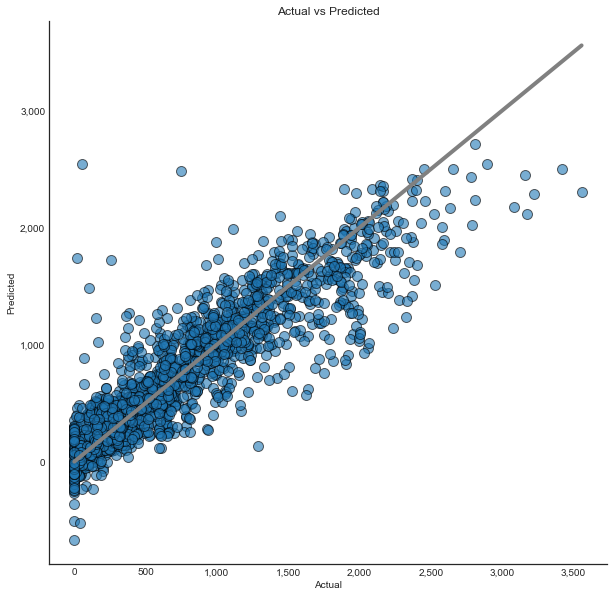

In [105]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=10,10 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=Y_test,
                y=Y_pred_lr,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(Y_test),max(Y_test)],
             y=[min(Y_test),max(Y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

### The performance is slightly better than the ridge regression model as we get an R2 score of 82 percent, and based on the graph we can conclude that their behaviour is similar.

### We finally go for a Random Forest Regressor, to check if ensemble models can do a better job at predicting demands for the test data

In [114]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_jobs=-1,
                              n_estimators=500,
                              min_samples_leaf=2,
                             ).fit(X_train,Y_train)

Y_pred_rf = model.predict(X_test)

mse = mean_squared_error(Y_test,Y_pred_rf)
rmse = np.sqrt(mse)
print(" RMSE ",rmse," R2 score ",r2_score(Y_test, Y_pred_rf))

 RMSE  221.49853220973395  R2 score  0.8760946247176062


/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/3749683709.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_xticklabels(xlabels)
/var/folders/yq/5lthdbc54mdc_m2xl17cf0ww0000gn/T/ipykernel_12874/3749683709.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  g.set_yticklabels(ylabels)


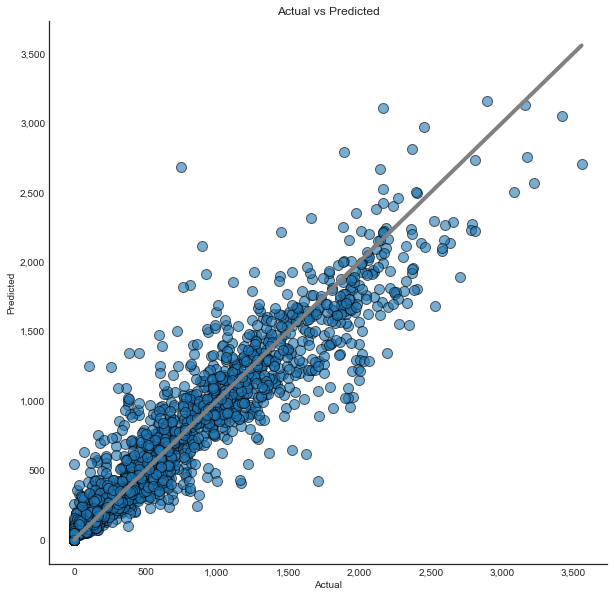

In [107]:
plt.style.use('seaborn-white')
plt.rcParams['figure.figsize']=10,10 

fig,ax = plt.subplots()
plt.title('Actual vs Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
g = sns.scatterplot(x=Y_test,
                y=Y_pred_rf,
                s=100,
                alpha=0.6,
                linewidth=1,
                edgecolor='black',
                ax=ax)
f = sns.lineplot(x=[min(Y_test),max(Y_test)],
             y=[min(Y_test),max(Y_test)],
             linewidth=4,
             color='gray',
             ax=ax)

xlabels = ['{:,.0f}'.format(x) for x in g.get_xticks()]
g.set_xticklabels(xlabels)
ylabels = ['{:,.0f}'.format(x) for x in g.get_yticks()]
g.set_yticklabels(ylabels)
sns.despine()

### The random forest regressor does the best job out of all the models, with an R2 score of 87.6 percent. Also, from the graph, it can be observed that the model does a good job at predicting values throughout the range of Y, and the points are all sticking close to the line.

### We now want to check the overall distributions of all the predictions with respect to the test data. We use a plotly express side by side box plot for this

In [119]:
import plotly.express as px

ModelA = pd.DataFrame({"model":"Polynomial","predictions":Y_pred_poly})
ModelB = pd.DataFrame({"model":"Ridge","predictions":Y_pred_rr})
ModelC = pd.DataFrame({"model":"Lasso","predictions":Y_pred_lr})
ModelD = pd.DataFrame({"model":"Random Forest","predictions":Y_pred_rf})
ModelE = pd.DataFrame({"model":"Actual","predictions":Y_test})

ModelsCompare = pd.concat([ModelA,ModelB,ModelC,ModelD,ModelE])

fig = px.box(ModelsCompare, x="model", y="predictions")
fig.show()

## We can see that the Random Forest is able to account for the test data the best, replicating it's quartiles and even it's outliers very well (These are outliers of the test data). I'll work on pulling more data from the Seoul Government website, repeat the analysis amd provide and update on how well the models perform.